In this notebook we would like to showcase the idea of *Feature Visualization* following the ideas in this [article](https://distill.pub/2017/feature-visualization/).

Described in a few words, our objective will be to optimize an input image which then will be fed to a Neural Network, as opposed to optimizing the network itself, which would be the classical aim of Deep Learning. So while leaving the network itself fixed we will instead try to find an *optimal* input image to it, given some conditions. This example will be using Google's *Inception* model. However any other vision based model might be used as well.

The conditions, under which we will consider an image to be optimal, can be of different types. One might be to find an image in a way such that a single neuron of the given network will experience maximal or minimal activation. Another one might be to maximize the class probability. Also we might ask to maximize/minimize the activation of a whole networks layer or only one of its channels.

Here we will be playing around with the last objective, that is: Finding an image such that a channels activation will become maximal. However our framework can easily be modified to be looking for other objectives as well. The article linked at the beginning of this notebook gives a nice overview over all the possible scenarios.

Now, to start off, we at first install our custom Deep Learning library.

<a target="_blank" href="https://colab.research.google.com/github/DavidBrandes/notebooks/blob/master/style_transfer_and_feature_visualization/feature_visualization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install git+https://github.com/DavidBrandes/deep_learning.git


  Cloning https://github.com/DavidBrandes/deep_learning.git to /tmp/pip-req-build-0gxnepbf
  Running command git clone --filter=blob:none --quiet https://github.com/DavidBrandes/deep_learning.git /tmp/pip-req-build-0gxnepbf
  Resolved https://github.com/DavidBrandes/deep_learning.git to commit 227b0e470e28ee5125e956e6dd897dcbcd54d45c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 6.1 MB/s eta 0:00:00
  Created wheel for dl: filename=dl-0.1.0-py3-none-any.whl size=9370 sha256=1ab0caec43df499f7a2f3a9a288233beaedfa3a14f9eb41e0a5768c7b713bbc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqi_paxt/wheels/af/63/95/078ce70c7a668301bba9c5b965d49285b19749e308aea35241
Successfully built dl


In [2]:
from torch.optim import Adam
import torch

from dl.utils import image as image_utils
from dl.model.convolutional.pretrained import get_googlenet_model
from dl.model.input.input import DreamModule, ActivationModule, InputModel
from dl.transform.image import RandomTransformation
from dl.parameter.image import FourierParameterization, UnitClipping
from dl.optimization.input import InputOptimizer

So, let us now create our objective. The *Activation Module* will give us as output the negative mean activation of the specified layer - in our case we picked *inception5b* - within our chosen *Inception* model. This negative mean activation is then the loss function which we will be trying to minimize. The minus before the mean stems from the consequence that we are actually trying to maximize the activation so that, by putting a minus in front of it, we revert it back to a minimization problem. As a side effect of that, our loss function will be negative - don't worry about it.

This *Activation Module* is then fed, together with the Inception base model to our custom *Input Optimization Model*. The arguments specified in the *modules* list below are: module class, name of the base model's layer to which this module should get appended to, a target which this module then tries to imitate (optional), the weight of this module in the whole optimization process (optional) and a slice of this layer which we want to use - in our case we selected the channel 22. (The "0" in front of the "22" is because the layer is internally represented by 4 dimensions, the first one being the batch dimension of which we trivially pick the first one - we only have one input image to start with)

As initial input to the optimization process we will be starting with random noise.

In [ ]:
# Selcting the optimization objective, layer and channel of the base model
modules = [(ActivationModule, 'inception5b', None, None, (0, 22))]

googlenet = get_googlenet_model()
model = InputModel(googlenet, modules)

epochs = 2500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = Adam
optimizer_kwargs = {"lr": 0.05}
shape = 512

# creating the input noise image
input_img = image_utils.random_image(shape)

Added ActivationModule module to layer inception5b


We are ready to start. The article mentioned in the beginning of this notebook introduces several ways of improving the quality of the output. In particular, parameterizing the image within a uncorrelated Fourier space instead of the basic pixel space and slightly transforming the image at the beginning of each optimization step seem to produce great improvements.

For now we will however be optimizing over the input image without using any further tweaks to improve our results and work our way there later. The only addition which we will be using is to clip the image into the range [0, 1] before each optimization step in order to prevent the process to reach any pixel values outside the desired bounds.

Optimizing
Final Loss -7.0064e+01


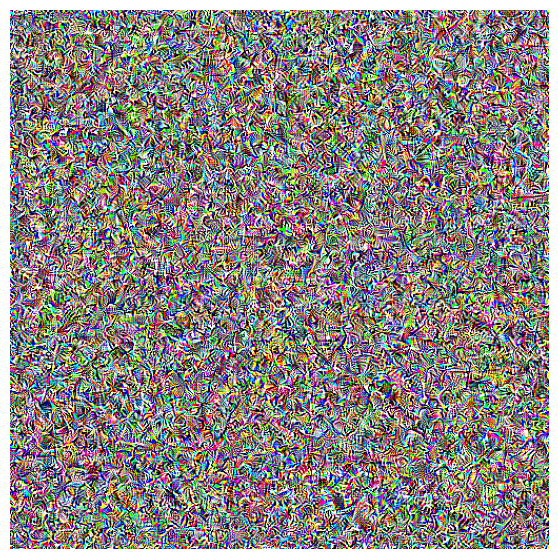

In [ ]:
inputOpt = InputOptimizer(model, optimizer, optimizer_kwargs=optimizer_kwargs,
                          #parameterization=FourierParameterization(),
                          #transformation=RandomTransformation(),
                          clipping=UnitClipping(),
                          epochs=epochs, device=device, leave=True)
# Set leave=False in order to see the individual epochs losses

output_img = inputOpt(input_img)
image_utils.show_image(output_img)

This looks already promising. We can see some structure within the optimized image from which we can deduce that the model didn't give us back simply some random noise.

Maybe by introducing some small and random transformations on the image before each optimization step we could improve our result even further?

Optimizing
Final Loss -2.4138e+01


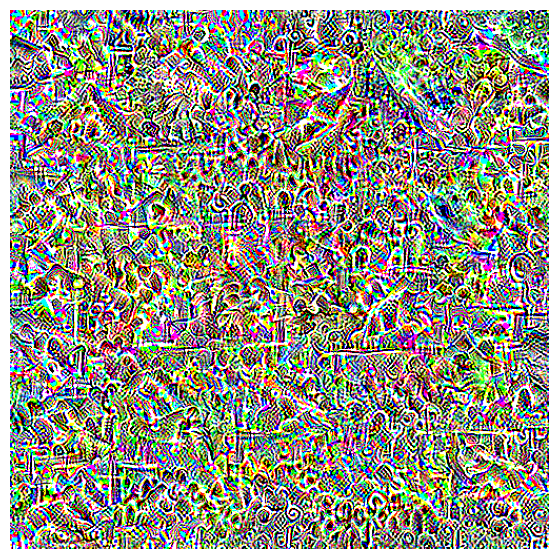

In [ ]:
inputOpt = InputOptimizer(model, optimizer, optimizer_kwargs=optimizer_kwargs,
                          #parameterization=FourierParameterization(),
                          transformation=RandomTransformation(),
                          clipping=UnitClipping(),
                          epochs=epochs, device=device, leave=True)
# Set leave=False in order to see the individual epochs losses

output_img = inputOpt(input_img)
image_utils.show_image(output_img)

This looks great! While we cannot really tell what this channel is trying to visualize we can certainly see some very interesting structures.

We now try to improve this result even further by parameterizing the image in a uncorrelated Fourier space instead of the basic pixel space. The idea is here that within the pixel space, neighboring pixels are highly correlated, thereby introducing lots of connections in between the optimization variables. Within the Fourier space we can lift this correlations and each optimization variable will get a bigger impact on the final result, not interfering to much with the other variables during the process. So while we cannot expect any new optima from this parameterization, we ease the process of finding them.

As we use the Sigmoid function in the last step of transforming an image from the uncorrelated space into the pixel space, bounding the variables to [0, 1], we no longer need to clip the image to these bounds.

Optimizing
Final Loss -2.0086e+01


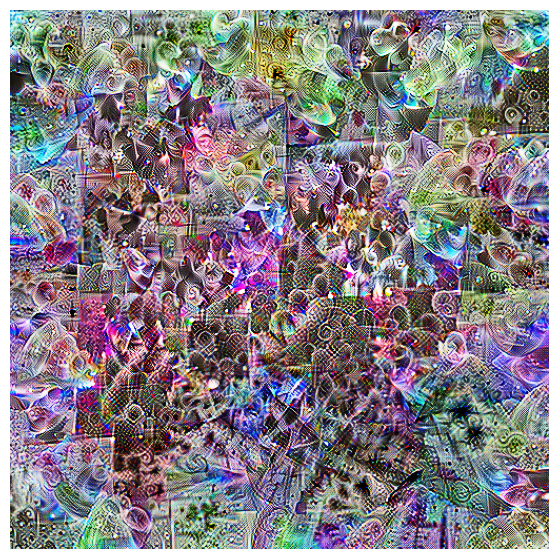

In [ ]:
inputOpt = InputOptimizer(model, optimizer, optimizer_kwargs=optimizer_kwargs,
                          parameterization=FourierParameterization(),
                          transformation=RandomTransformation(),
                          #clipping=UnitClipping(),
                          epochs=epochs, device=device, leave=True)
# Set leave=False in order to see the individual epochs losses

output_img = inputOpt(input_img)
image_utils.show_image(output_img)

Pretty cool!

As the objectives are quite similar, we can also try to recreate what is known as *Deep Dream*. The difference to the approach from before is that instead of starting off from random noise, we can input an actual image into the model which is then getting refined. (Also we use the square norm of the picked layers activation as our loss.)

Like before we will use as the base model Google's *Inception* and now try to excite its whole *inception4a* layer as strong as possible.

In [15]:
# Selcting the optimization objective and layer of the base model
modules = [(DreamModule, 'inception4a', None, None, None)]

googlenet = get_googlenet_model()
model = InputModel(googlenet, modules)

# In order to not stray away too far from our input image we decrease the number
# of epochs. Alternatively we could try to introduce an additional Content Loss
# Module (check out the Style Transfer notebook for more info)
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = Adam
optimizer_kwargs = {"lr": 0.05}
max_shape = 512

Added DreamModule module to layer inception4a


For the input we will be using *Leonardo da Vinci's* mural painting *Il Cenacolo - The Last Supper*. Lets load and resize it.

--2023-09-01 22:55:03--  https://upload.wikimedia.org/wikipedia/commons/4/4b/%C3%9Altima_Cena_-_Da_Vinci_5.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9242484 (8.8M) [image/jpeg]
Saving to: ‘/content/input.jpg’

/content/input.jpg  100%[===================>]   8.81M  21.3MB/s    in 0.4s    

2023-09-01 22:55:04 (21.3 MB/s) - ‘/content/input.jpg’ saved [9242484/9242484]



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Image Shape: (288, 512)


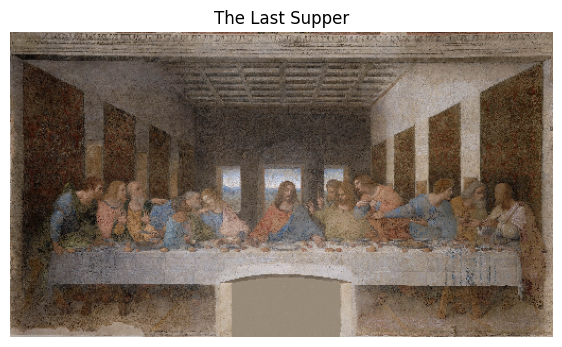

In [5]:
!wget https://upload.wikimedia.org/wikipedia/commons/4/4b/%C3%9Altima_Cena_-_Da_Vinci_5.jpg -O /content/input.jpg

input_img_path = "/content/input.jpg"

input_img = image_utils.load_image(input_img_path)

# Crpping the image to restrain its maximal size
(input_img,), shape = image_utils.max_image_crops([input_img], max_size=max_shape)

print(f"Image Shape: {shape}")
image_utils.show_image(input_img, title="The Last Supper")

The optimization process is ready to be run again. Since we had such great results with the two additions from before we start off with them included right away.

Optimizing
Final Loss -2.3120e+00


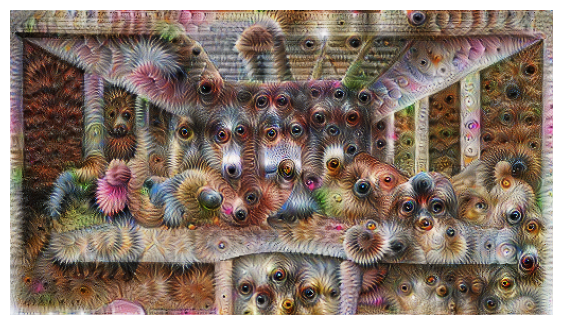

In [16]:
inputOpt = InputOptimizer(model, optimizer, optimizer_kwargs=optimizer_kwargs,
                          parameterization=FourierParameterization(),
                          transformation=RandomTransformation(),
                          #clipping=UnitClipping(),
                          epochs=epochs, device=device, leave=True)
# Set leave=False in order to see the individual epochs losses

output_img = inputOpt(input_img)
image_utils.show_image(output_img)